In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import constants as const
import warnings
from scipy.stats import bootstrap
import scipy
from scipy import interpolate
import math
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
from scipy.stats import skewnorm

dataLI = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\STPM_improved_210721.csv",delimiter=",")
dataEA = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Exoplanet_Archive.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI

earth_like_rocky  = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")
pure_rock         = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\pure-Rock (100% MgSiO3).txt",delimiter = "\t")
H20_50_300K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_300 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_500K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_500 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_700K       = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_700 K_1mili-bar surface temprture.txt",delimiter = "\t")

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume



In [3]:
# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc
star_eff_LI          = dataLI.Teff_K
pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade            # [Earth Radius]
period_EA            = dataEA.pl_orbper          # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature
st_eff_EA            = dataEA.st_teff            # Star effective temprature
st_eff_up_EA         = dataEA.st_tefferr1        # Star upper err effective temprature
st_eff_low_EA        = dataEA.st_tefferr2        # Star lower err effective temprature
disc_year_EA         = dataEA.disc_year


In [4]:
planet2      = []; planet_i2       = []; planet_eq2   = []
disc_year2   = []; st_eff2         = []
radius2      = []; radius_up2      = []; radius_low2  = []
mass2        = []; mass_up2        = []; mass_low2    = []
density2     = []; density_up2     = []; density_low2 = []
other_names = ['LHS 1140 c' ,'L 168-9 b', 'L 168-9 c']

for i in range(0,len(planet_name_EA)):
    if ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.08 and radius_EA[i]<4:
        if "M" in str(st_spectype_EA[i]) or st_eff_EA[i] < 3500:
            if st_eff_EA[i] < 3997:
                if ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.25 and math.isnan(density_unc_low_EA[i]) == False:
                    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names:
                        st_eff2.append(st_eff_EA[i])
                        planet_eq2.append(pl_eq_EA[i]); planet2.append(planet_name_EA[i]); disc_year2.append(disc_year_EA[i])
                        radius2.append(dataEA.pl_rade[i]); radius_up2.append(dataEA.pl_radeerr1[i]); radius_low2.append(dataEA.pl_radeerr2[i])
                        density2.append(dataEA.pl_dens[i]); density_up2.append(dataEA.pl_denserr1[i]); density_low2.append(dataEA.pl_denserr2[i])
                        mass2.append(dataEA.pl_bmasse[i]); mass_up2.append(dataEA.pl_bmasseerr1[i]);  mass_low2.append(dataEA.pl_bmasseerr2[i])


In [7]:
planet2

['AU Mic c',
 'GJ 3090 b',
 'GJ 367 b',
 'HD 260655 b',
 'HD 260655 c',
 'Kepler-26 b',
 'Kepler-26 c',
 'LHS 1140 b',
 'LTT 1445 A b',
 'LTT 1445 A c',
 'TOI-1075 b',
 'TOI-1201 b',
 'TOI-1470 b',
 'TOI-244 b']

Text(0.5, 1.0, 'STPMs Luque Improved sample')

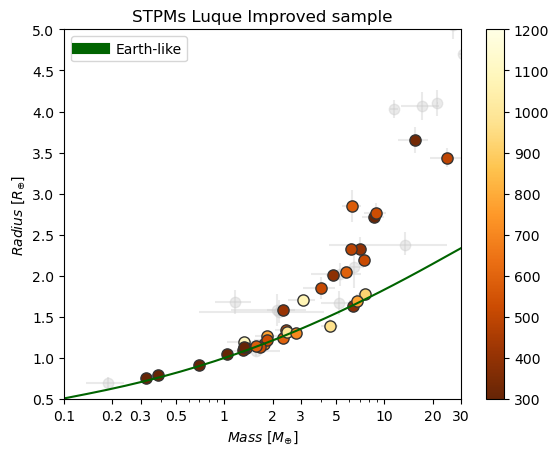

In [8]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
mass_err_LI   = [mass_unc_low_LI,mass_unc_up_LI]
radius_err_LI = [radius_unc_low_LI,radius_unc_up_LI]
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
# plt.scatter(mass_LI[i], radius_LI[i], s=72, facecolors='none', edgecolors='0.2')

plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like")

norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
densities = []
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass_LI[i], radius_LI[i], c=[pl_eq_LI[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
        densities.append(density_LI[i])
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("STPMs Luque Improved sample")

Text(0.5, 1.0, 'LIV34 planets')

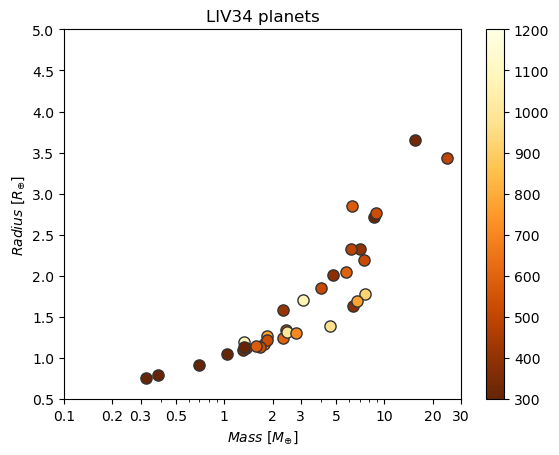

In [5]:
mass = []; radius = []; planet = []
norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values

for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass_LI[i], radius_LI[i], c=[pl_eq_LI[i]], cmap=cmap, norm = norm,marker='o',s=65, edgecolors='0.2')   
        densities.append(density_LI[i])
        mass.append(mass_LI[i])
        radius.append(radius_LI[i])
        planet.append(planet_name_LI[i])
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.title("LIV34 planets")

In [6]:
earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

H20_50_500K_mass_g        = earth_Mass*np.array(H20_50_500K["Mass"])
H20_50_500K_radius_cm     = earth_Radius*np.array(H20_50_500K["Radius"])
H20_50_500K_density_g_cm3 = (H20_50_500K_mass_g) / ((4/3)*(np.pi)*(np.power(H20_50_500K_radius_cm,3))   ) 

def rocky_density(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def rocky_density2(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3/earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()


Text(0.5, 0, '$Mass\\ [M_{\\oplus}]$')

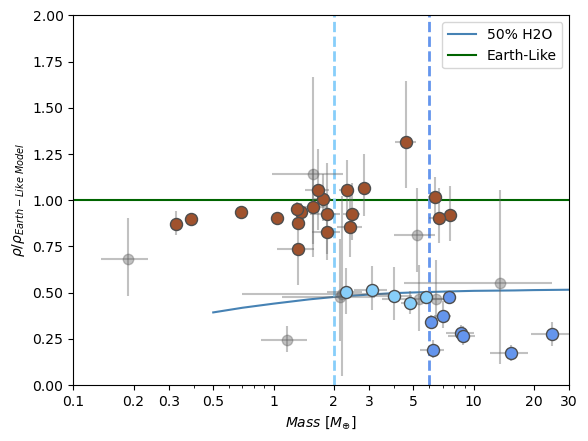

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# Plot the lines
fig, ax = plt.subplots()
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)

index = []
mass_rocky = []; mass_water = []; mass_puffy = [];
radius_rocky = []; radius_water = []; radius_puffy = [];
density_rocky = []; density_water = []; density_puffy = [];
planet_rocky = []; planet_water = []; planet_puffy = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]
plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
            mass_rocky.append(mass_LI[i])
            radius_rocky.append(radius_LI[i])
            density_rocky.append(density_LI[i])
            planet_rocky.append(planet_name_LI[i])
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_puffy.append(i)
            mass_puffy.append(mass_LI[i])
            radius_puffy.append(radius_LI[i])
            density_puffy.append(density_LI[i])
            planet_puffy.append(planet_name_LI[i])
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_water.append(i)
            mass_water.append(mass_LI[i])
            radius_water.append(radius_LI[i])
            density_water.append(density_LI[i])
            planet_water.append(planet_name_LI[i])
plt.scatter(mass_LI[index_rocky], density_norm[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_LI[index_puffy], density_norm[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_LI[index_water], density_norm[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")

weight = 1/(np.sqrt(density_err_LI[0][index]**2 +density_err_LI[1][index]**2 ) )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

plt.xlim(0.1, 30)
plt.ylim(0, 2); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.legend()
plt.xlabel("$Mass\ [M_{\oplus}]$")

In [32]:
radius_puffy

[2.19, 2.33, 2.711, 2.85, 2.332, 3.44, 2.77, 3.65]

In [93]:
planet_data = list(zip(planet_water, mass_water, radius_water,density_water))
sorted_planet_data = sorted(planet_data, key=lambda x: x[0])
sorted_planets_water, sorted_masses_water, sorted_radii_water,sorted_density_water = zip(*sorted_planet_data)

planet_data = list(zip(planet_puffy, mass_puffy, radius_puffy,density_puffy))
sorted_planet_data = sorted(planet_data, key=lambda x: x[0])
sorted_planets_puffy,sorted_masses_puffy, sorted_radii_puffy,sorted_density_puffy = zip(*sorted_planet_data)

planet_data = list(zip(planet_rocky, mass_rocky, radius_rocky,density_rocky))
sorted_planet_data = sorted(planet_data, key=lambda x: x[0])
sorted_planets_rocky,sorted_masses_rocky, sorted_radii_rocky,sorted_density_rocky = zip(*sorted_planet_data)


In [139]:
water_d_core   = [0.38, 0.41, 0.55, 0.29, 0.39]
rocky_d_core   = [0.81,0.73,0.64,0.66,0.73,0.67,0.67,0.74,0.65,0.73,0.70,0.67,0.65,0.64,0.68,0.67,0.66,0.66,0.64,0.62,0.64]
water_d_mantle = [0.27,0.25,0.17,0.21,0.24]
puffy_d_mantle = [0.16,0.27,0.22,0.18,0.11,0.14,0.17,0.20]
rocky_d_mantle = [0.04,0.09,0.10,0.16,0.09,0.12,0.12,0.08,0.14,0.09,0.09,0.12,0.13,0.14,0.13,0.14,0.15,0.16,0.18,0.19,0.18]
water_d_water  = [0.26,0.21,0.15,0.37,0.23]
puffy_d_water  = [0.29,0.28,0.34,0.25,0.14,0.16,0.37,0.39]
rocky_d_water  = [0.05,0.08,0.13,0.12,0.09,0.11,0.09,0.08,0.11,0.08,0.10,0.11,0.12,0.11,0.10,0.09,0.09,0.09,0.11,0.12,0.10]


In [140]:
len(rocky_d_water)

21

Text(0.5, 1.0, 'LIV34 planets')

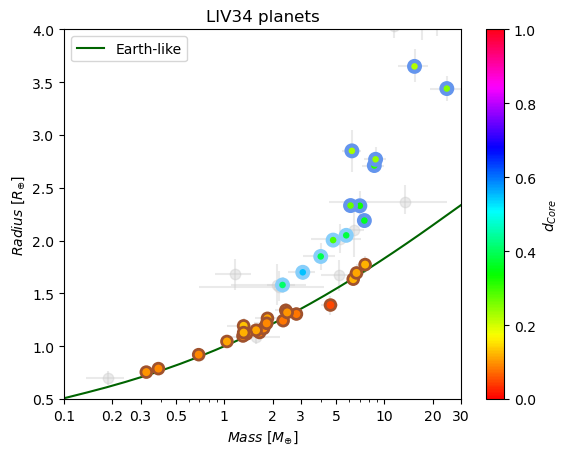

In [134]:
import matplotlib.pyplot as plt
from matplotlib import colors

plt.figure()
norm = colors.Normalize(vmin=0, vmax=1)
cmap = plt.cm.get_cmap('hsv')

# Create scatter plots
plt.scatter(sorted_masses_rocky, sorted_radii_rocky, c=rocky_d_core, cmap=cmap, norm=norm,s=60, edgecolor = "sienna",linewidth=2)
plt.scatter(sorted_masses_puffy, sorted_radii_puffy, c=puffy_d_core, cmap=cmap, norm=norm,s=60, edgecolor="cornflowerblue",linewidth=3)
plt.scatter(sorted_masses_water, sorted_radii_water, c=water_d_core, cmap=cmap, norm=norm,s=60, edgecolor="lightskyblue",linewidth=3)
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)

plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like",zorder=-32)

plt.legend()
cbar = plt.colorbar(label = "$d_{Core}$")
plt.scatter(100, 100, c="None", edgecolor = "sienna",linewidth=3,label = "Rocky Planets")
plt.scatter(100, 100, c="None", edgecolor="cornflowerblue",linewidth=3,label = "Puffy Planets")
plt.scatter(100, 100, c="None", edgecolor="lightskyblue",linewidth=3,label = "Water Planets")

plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,4)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.title("LIV34 planets")

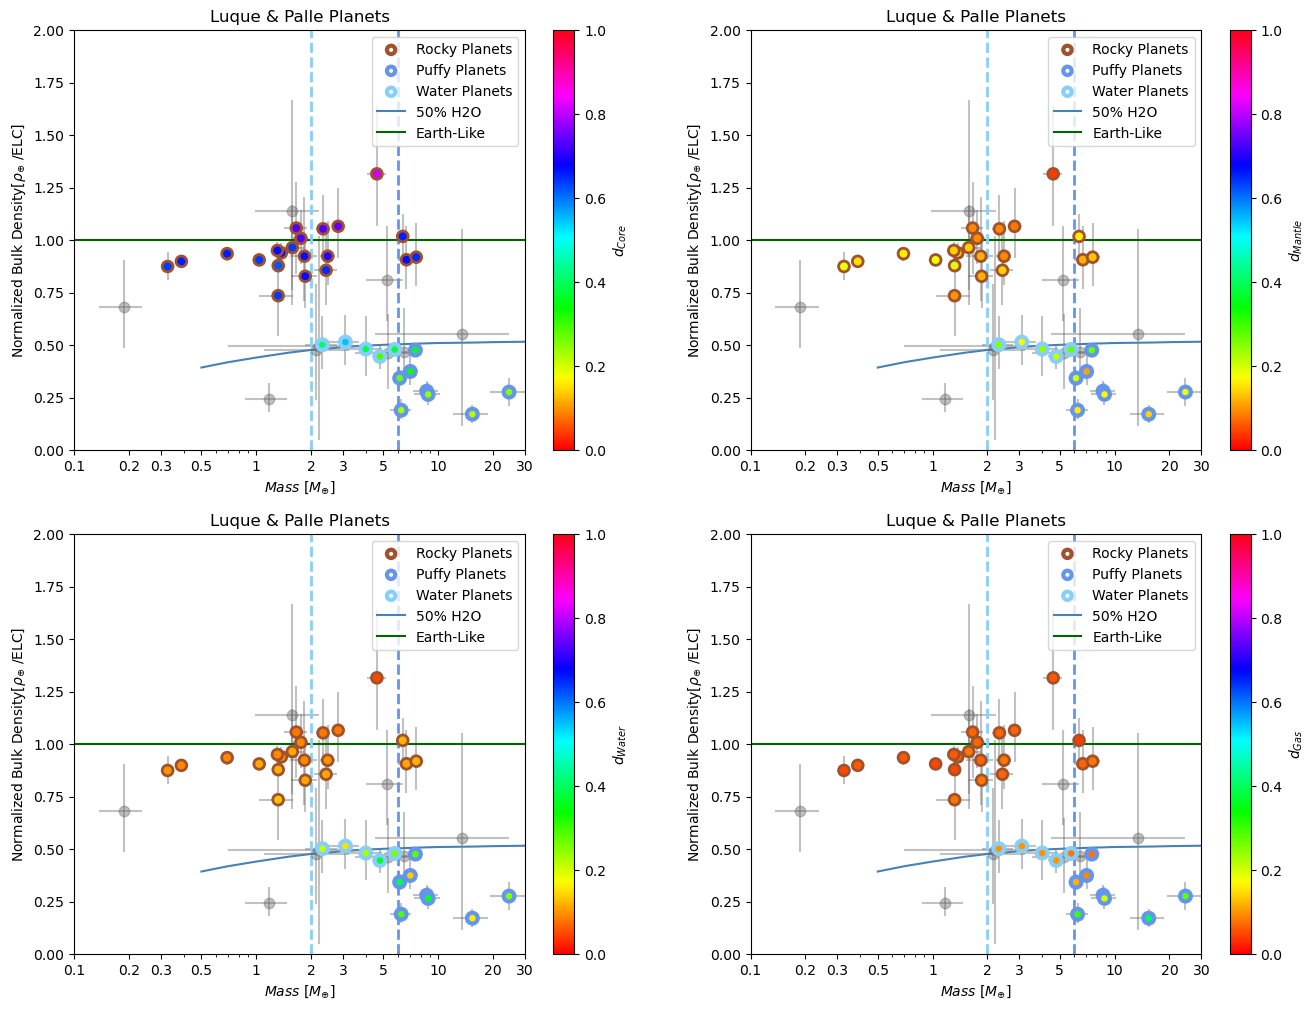

In [164]:
fig, ax = plt.subplots(figsize=(16,12))
plt.subplot(2, 2, 1)  # 1 row, 2 columns, first subplot
water_d_core   = [0.38, 0.41, 0.55, 0.29, 0.39]
rocky_d_core   = [0.81,0.73,0.64,0.66,0.73,0.67,0.67,0.74,0.65,0.73,0.70,0.67,0.65,0.64,0.68,0.67,0.66,0.66,0.64,0.62,0.64]
water_d_mantle = [0.27,0.25,0.17,0.21,0.24]
puffy_d_mantle = [0.16,0.27,0.22,0.18,0.11,0.14,0.17,0.20]
rocky_d_mantle = [0.04,0.09,0.10,0.16,0.09,0.12,0.12,0.08,0.14,0.09,0.09,0.12,0.13,0.14,0.13,0.14,0.15,0.16,0.18,0.19,0.18]
water_d_water  = [0.26,0.21,0.15,0.37,0.23]
puffy_d_water  = [0.29,0.28,0.34,0.25,0.14,0.16,0.37,0.39]
rocky_d_water  = [0.05,0.08,0.13,0.12,0.09,0.11,0.09,0.08,0.11,0.08,0.10,0.11,0.12,0.11,0.10,0.09,0.09,0.09,0.11,0.12,0.10]
water_d_gas    = [0.08,0.10,0.10,0.10,0.10]
puffy_d_gas    = [0.30,0.08,0.06,0.28,0.09,0.40,0.20,0.12]
rocky_d_gas    = [0.06,0.07,0.08,0.04,0.07,0.08,0.07,0.07,0.07,0.07,0.08,0.07,0.08,0.08,0.07,0.06,0.06,0.06,0.05,0.05,0.05]
plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
plt.scatter(sorted_masses_rocky, sorted_density_rocky/ np.array(rocky_density(sorted_masses_rocky)), c=rocky_d_core, cmap=cmap, norm=norm,s=60, edgecolor = "sienna",linewidth=2)
plt.scatter(sorted_masses_puffy, sorted_density_puffy/ np.array(rocky_density(sorted_masses_puffy)), c=puffy_d_core, cmap=cmap, norm=norm,s=60, edgecolor="cornflowerblue",linewidth=3)
plt.scatter(sorted_masses_water, sorted_density_water/ np.array(rocky_density(sorted_masses_water)), c=water_d_core, cmap=cmap, norm=norm,s=60, edgecolor="lightskyblue",linewidth=3)

cbar = plt.colorbar(label = "$d_{Core}$")
plt.scatter(100, 100, c="None", edgecolor = "sienna",linewidth=3,label = "Rocky Planets")
plt.scatter(100, 100, c="None", edgecolor="cornflowerblue",linewidth=3,label = "Puffy Planets")
plt.scatter(100, 100, c="None", edgecolor="lightskyblue",linewidth=3,label = "Water Planets")

plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)

plt.legend()
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("Normalized Bulk Density$[ρ_{\oplus}$ /ELC]")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0,2)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.title("Luque & Palle Planets")

plt.subplot(2, 2, 2)  # 1 row, 2 columns, first subplot
plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
plt.scatter(sorted_masses_puffy, sorted_density_puffy/ np.array(rocky_density(sorted_masses_puffy)), c=puffy_d_mantle, cmap=cmap, norm=norm,s=60, edgecolor="cornflowerblue",linewidth=3)
plt.scatter(sorted_masses_rocky, sorted_density_rocky/ np.array(rocky_density(sorted_masses_rocky)), c=rocky_d_mantle, cmap=cmap, norm=norm,s=60, edgecolor = "sienna",linewidth=2)
plt.scatter(sorted_masses_water, sorted_density_water/ np.array(rocky_density(sorted_masses_water)), c=water_d_mantle, cmap=cmap, norm=norm,s=60, edgecolor="lightskyblue",linewidth=3)

cbar = plt.colorbar(label = "$d_{Mantle}$")
plt.scatter(100, 100, c="None", edgecolor = "sienna",linewidth=3,label = "Rocky Planets")
plt.scatter(100, 100, c="None", edgecolor="cornflowerblue",linewidth=3,label = "Puffy Planets")
plt.scatter(100, 100, c="None", edgecolor="lightskyblue",linewidth=3,label = "Water Planets")

plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)

plt.legend()
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("Normalized Bulk Density$[ρ_{\oplus}$ /ELC]")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0,2)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.title("Luque & Palle Planets")

plt.subplot(2, 2, 3)  # 1 row, 2 columns, first subplot
plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
plt.scatter(sorted_masses_puffy, sorted_density_puffy/ np.array(rocky_density(sorted_masses_puffy)), c=puffy_d_water, cmap=cmap, norm=norm,s=60, edgecolor="cornflowerblue",linewidth=3)
plt.scatter(sorted_masses_water, sorted_density_water/ np.array(rocky_density(sorted_masses_water)), c=water_d_water, cmap=cmap, norm=norm,s=60, edgecolor="lightskyblue",linewidth=3)
plt.scatter(sorted_masses_rocky, sorted_density_rocky/ np.array(rocky_density(sorted_masses_rocky)), c=rocky_d_water, cmap=cmap, norm=norm,s=60, edgecolor = "sienna",linewidth=2)

cbar = plt.colorbar(label = "$d_{Water}$")
plt.scatter(100, 100, c="None", edgecolor = "sienna",linewidth=3,label = "Rocky Planets")
plt.scatter(100, 100, c="None", edgecolor="cornflowerblue",linewidth=3,label = "Puffy Planets")
plt.scatter(100, 100, c="None", edgecolor="lightskyblue",linewidth=3,label = "Water Planets")

plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)

plt.legend()
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("Normalized Bulk Density$[ρ_{\oplus}$ /ELC]")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0,2)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.title("Luque & Palle Planets")

plt.subplot(2, 2, 4)  # 1 row, 2 columns, first subplot
plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
plt.scatter(sorted_masses_water, sorted_density_water/ np.array(rocky_density(sorted_masses_water)), c=water_d_gas, cmap=cmap, norm=norm,s=60, edgecolor="lightskyblue",linewidth=3)
plt.scatter(sorted_masses_puffy, sorted_density_puffy/ np.array(rocky_density(sorted_masses_puffy)), c=puffy_d_gas, cmap=cmap, norm=norm,s=60, edgecolor="cornflowerblue",linewidth=3)
plt.scatter(sorted_masses_rocky, sorted_density_rocky/ np.array(rocky_density(sorted_masses_rocky)), c=rocky_d_gas, cmap=cmap, norm=norm,s=60, edgecolor = "sienna",linewidth=2)

cbar = plt.colorbar(label = "$d_{Gas}$")
plt.scatter(100, 100, c="None", edgecolor = "sienna",linewidth=3,label = "Rocky Planets")
plt.scatter(100, 100, c="None", edgecolor="cornflowerblue",linewidth=3,label = "Puffy Planets")
plt.scatter(100, 100, c="None", edgecolor="lightskyblue",linewidth=3,label = "Water Planets")

plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)

plt.legend()
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("Normalized Bulk Density$[ρ_{\oplus}$ /ELC]")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0,2)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.title("Luque & Palle Planets")
image_name = 'LIV34_mdn.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)


Text(0.5, 1.0, 'LIV34 planets')

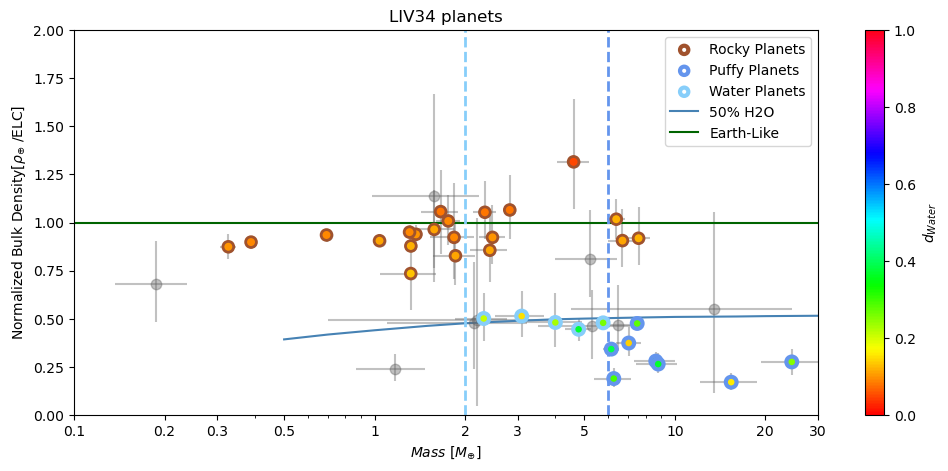

In [148]:
fig, ax = plt.subplots(figsize=(12,5))
plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
plt.scatter(sorted_masses_puffy, sorted_density_puffy/ np.array(rocky_density(sorted_masses_puffy)), c=puffy_d_water, cmap=cmap, norm=norm,s=60, edgecolor="cornflowerblue",linewidth=3)
plt.scatter(sorted_masses_water, sorted_density_water/ np.array(rocky_density(sorted_masses_water)), c=water_d_water, cmap=cmap, norm=norm,s=60, edgecolor="lightskyblue",linewidth=3)
plt.scatter(sorted_masses_rocky, sorted_density_rocky/ np.array(rocky_density(sorted_masses_rocky)), c=rocky_d_water, cmap=cmap, norm=norm,s=60, edgecolor = "sienna",linewidth=2)

cbar = plt.colorbar(label = "$d_{Water}$")
plt.scatter(100, 100, c="None", edgecolor = "sienna",linewidth=3,label = "Rocky Planets")
plt.scatter(100, 100, c="None", edgecolor="cornflowerblue",linewidth=3,label = "Puffy Planets")
plt.scatter(100, 100, c="None", edgecolor="lightskyblue",linewidth=3,label = "Water Planets")

plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)

plt.legend()
plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("Normalized Bulk Density$[ρ_{\oplus}$ /ELC]")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0,2)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.title("LIV34 planets")

In [138]:
len(rocky_d_water)

22

In [101]:
sorted_density_rocky/np.array(rocky_density(sorted_masses_rocky))

array([1.3151875 , 1.05682803, 0.7350329 , 1.0173022 , 1.00811376,
       0.82740016, 0.92290608, 1.06533975, 0.85604084, 1.05325345,
       0.92299368, 0.90622145, 0.91829817, 0.96415975, 0.93888719,
       0.9501256 , 0.8983401 , 0.9352722 , 0.90530759, 0.87810191,
       0.87403311])

Text(0.5, 1.0, 'LIV34 planets')

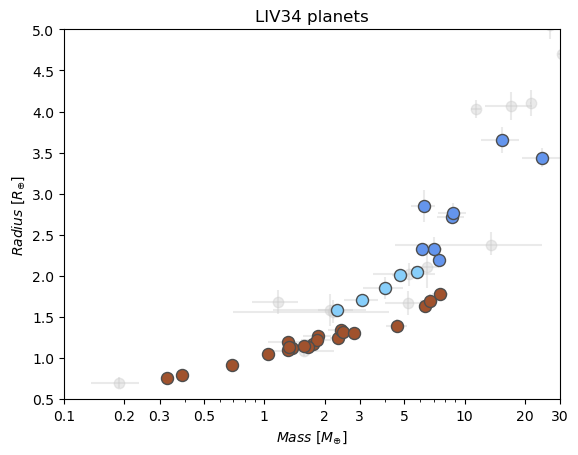

In [11]:
plt.scatter(mass_rocky, radius_rocky,color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_puffy, radius_puffy,color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_water, radius_water,color = "lightskyblue",s = 75, edgecolor = "0.3")
mass_err_LI   = [mass_unc_low_LI,mass_unc_up_LI]
radius_err_LI = [radius_unc_low_LI,radius_unc_up_LI]
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)

plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.title("LIV34 planets")

Text(0.5, 1.0, 'LIV34 planets')

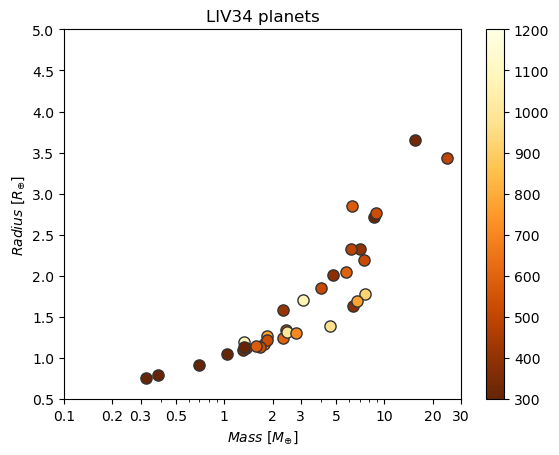

In [23]:
mass = []; radius = []; density = []; planet = [];
norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values

for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass_LI[i], radius_LI[i], c=[pl_eq_LI[i]], cmap=cmap, norm = norm,marker='o',s=65, edgecolors='0.2')   
        density.append(density_LI[i])
        mass.append(mass_LI[i])
        radius.append(radius_LI[i])
        planet.append(planet_name_LI[i])
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.title("LIV34 planets")


(array([1., 0., 1., 0., 0., 1., 0., 1., 0., 1.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

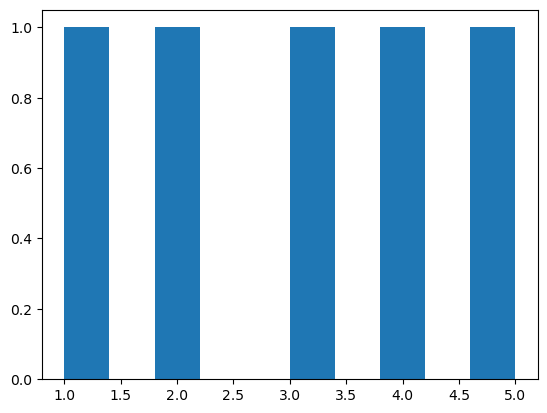

In [2]:
plt.hist([1,2,3,4,5])

Text(0.5, 1.0, 'LIV34 planets')

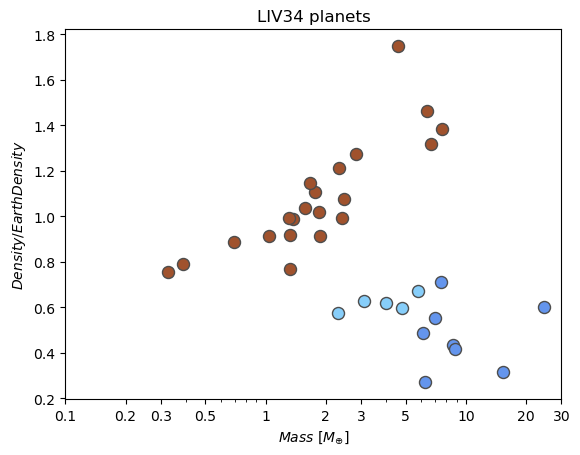

In [13]:
plt.scatter(mass_rocky, density_rocky/earth_density,color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_puffy, density_puffy/earth_density,color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_water, density_water/earth_density,color = "lightskyblue",s = 75, edgecolor = "0.3")

plt.xlabel("$Mass\ [M_{\oplus}]$"); plt.ylabel("$Density/Earth Density$")
plt.xscale("log"); plt.xlim(0.1,30);
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.title("LIV34 planets")


## Adding planets to the sample

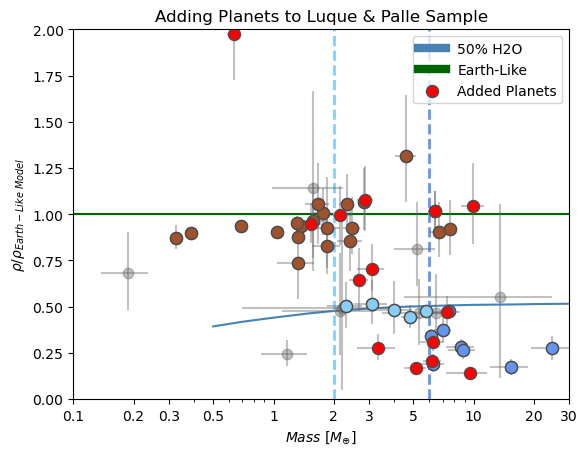

In [14]:
fig, ax = plt.subplots()
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)

xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]
plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_water.append(i)
plt.scatter(mass_LI[index_rocky], density_norm[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_LI[index_puffy], density_norm[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_LI[index_water], density_norm[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")

plt.xlim(0.1, 30)
plt.ylim(0, 2); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.legend()

plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),color = "red",s=20, edgecolor = "0.3")
mass_err_LI = np.array([mass_unc_low_LI, mass_unc_up_LI])
density_err_LI = [density_unc_low_LI / rocky_density(mass_LI), density_unc_up_LI / rocky_density(mass_LI)]
density_norm = density_LI / rocky_density(mass_LI)

index = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4:
        index.append(i) 
xerr = [mass_err_LI[0][index], mass_err_LI[1][index]]
yerr = [density_err_LI[0][index], density_err_LI[1][index]]
#plt.errorbar(mass_LI[index], density_norm[index], xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(planet_name_LI)):
    if radius_LI[i] < 4 and planet_name_LI[i] in planets:
        if abs(1- density_norm[i]) < abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_rocky.append(i)
        if mass_LI[i] >= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_puffy.append(i)
        if 2 <= mass_LI[i] <= 6 and abs(1- density_norm[i]) > abs(density_norm[i] - h20model_density(mass_LI[i])):
            index_water.append(i)
plt.scatter(mass_LI[index_rocky], density_norm[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(mass_LI[index_puffy], density_norm[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(mass_LI[index_water], density_norm[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")

plt.xlim(0.1, 30)
plt.ylim(0, 2); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.title("Adding Planets to Luque & Palle Sample")
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),color = "red",s=75, edgecolor = "0.3",label = "Added Planets")

xerr = [np.abs(mass_low2), mass_up2]
yerr = [np.abs(density_low2) / np.array(rocky_density(mass2)) , density_up2 / np.array(rocky_density(mass2)) ]
plt.errorbar(mass2, np.array(density2)/ np.array(rocky_density(mass2)), xerr=xerr, yerr=yerr, fmt='.', markersize=15, color="0.4", zorder=-32, alpha=0.4)
plt.xlabel("$Mass\ [M_{\oplus}]$")
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)

image_name = 'LIV34_add_DM1.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

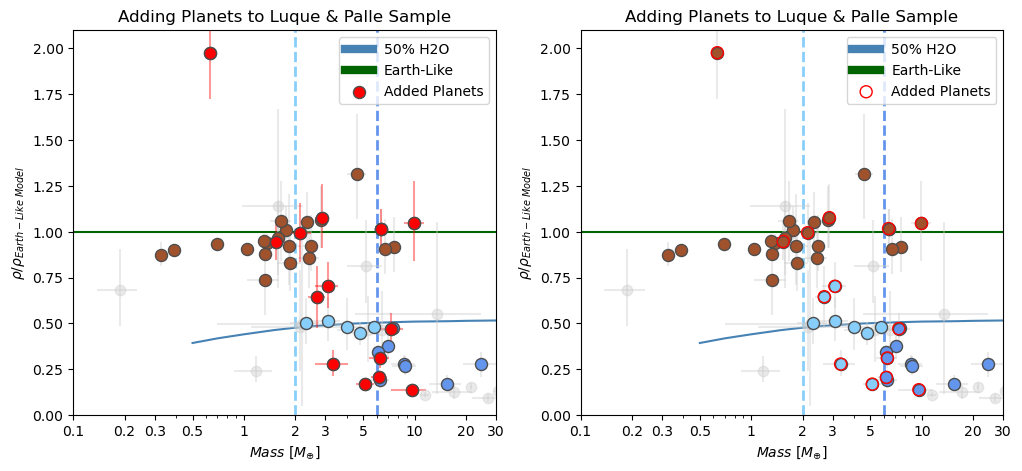

In [425]:
fig, ax = plt.subplots(figsize=(12,5))
masses_add  = np.concatenate([mass_LI[index],mass2])
radii_add   = np.concatenate([radius_LI[index],radius2])
density_add = np.concatenate([density_norm[index],np.array(density2) / np.array(rocky_density(mass2))])
selected_planets = [planet_name_LI[i] for i in index if i < len(planet_name)]
planet_name = np.concatenate([selected_planets,planet2])
xerr = [np.concatenate([mass_err_LI[0][index],np.abs(mass_low2)]), np.concatenate([mass_err_LI[1][index],np.abs(mass_up2)])]
yerr = [np.concatenate([density_err_LI[0][index],np.abs(density_low2/ np.array(rocky_density(mass2)))]) , np.concatenate([density_err_LI[1][index], np.abs(density_up2/ np.array(rocky_density(mass2))) ])]
no_plot = []
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] not in planets:
        no_plot.append(planet_name_LI[i])
        
index_puffy = []; index_water = []; index_rocky = []    
for i in range(0, len(planet_name)):
    if radii_add[i] < 4 and planet_name[i] not in no_plot:
        if planet_name[i] in planets or planet_name[i] in planet2:
            if abs(1- density_add[i]) < abs(density_add[i] - h20model_density(masses_add[i])):
                index_rocky.append(i)
            if masses_add[i] >= 6 and abs(1- density_add[i]) > abs(density_add[i] - h20model_density(masses_add[i])):
                index_puffy.append(i)
            if 2 <= masses_add[i] <= 6 and abs(1- density_add[i]) > abs(density_add[i] - h20model_density(masses_add[i])):
                index_water.append(i)

weight = 1/(yerr[0]**2 +yerr[1]**2 )
weight_rocky = weight[index_rocky]
weight_water = weight[index_water]
weight_puffy = weight[index_puffy]

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.errorbar(mass_LI,density_LI/ np.array(rocky_density(mass_LI)),xerr = mass_err_LI, yerr=density_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.errorbar(mass2,density2/ np.array(rocky_density(mass2)),xerr = [np.abs(mass_low2),mass_up2],yerr = [np.abs(density_low2/ np.array(rocky_density(mass2))),np.abs(density_up2/ np.array(rocky_density(mass2)))],fmt='.',markersize = 15,color = "red",zorder=-32,alpha = 0.4)
plt.scatter(masses_add[index_rocky], density_add[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(masses_add[index_puffy], density_add[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(masses_add[index_water], density_add[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")
plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),color = "red",s=75, edgecolor = "0.3",label = "Added Planets")

plt.xlim(0.1, 30)
plt.ylim(0, 2.1); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.title("Adding Planets to Luque & Palle Sample")
plt.xlabel("$Mass\ [M_{\oplus}]$")
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.plot(H20_50_500K["Mass"], H20_50_500K_density_g_cm3 / rocky_density(H20_50_500K["Mass"]), "-", color="steelblue", label="50% H2O", zorder=-32)
plt.plot(earth_like_rocky["Mass"], earth_like_rocky_density_g_cm3 / rocky_density(earth_like_rocky["Mass"]), "-", color="darkgreen", label="Earth-Like", zorder=-32)
plt.vlines(2,0,20,colors = "lightskyblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.vlines(6,0,20,colors = "cornflowerblue",linestyle = "dashed",zorder=-32,linewidth = 2)
plt.errorbar(mass_LI,density_LI/ np.array(rocky_density(mass_LI)),xerr = mass_err_LI, yerr=density_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.errorbar(mass2,density2/ np.array(rocky_density(mass2)),xerr = [np.abs(mass_low2),mass_up2],yerr = [np.abs(density_low2/ np.array(rocky_density(mass2))),np.abs(density_up2/ np.array(rocky_density(mass2)))],fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.scatter(masses_add[index_rocky], density_add[index_rocky],color = "sienna",s=75, edgecolor = "0.3")
plt.scatter(masses_add[index_puffy], density_add[index_puffy],color = "cornflowerblue",s = 75, edgecolor = "0.3")
plt.scatter(masses_add[index_water], density_add[index_water],color = "lightskyblue",s = 75, edgecolor = "0.3")
plt.scatter(mass2,np.array(density2) / np.array(rocky_density(mass2)),facecolor = "None",s=75, edgecolor = "red",label = "Added Planets")

plt.xlim(0.1, 30)
plt.ylim(0, 2.1); plt.xscale("log")
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
plt.ylabel('$ρ / ρ_{Earth-Like\ Model}$')
plt.title("Adding Planets to Luque & Palle Sample")
plt.xlabel("$Mass\ [M_{\oplus}]$")
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(6.0)
    
image_name = 'LIV34_add_DM.png'
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

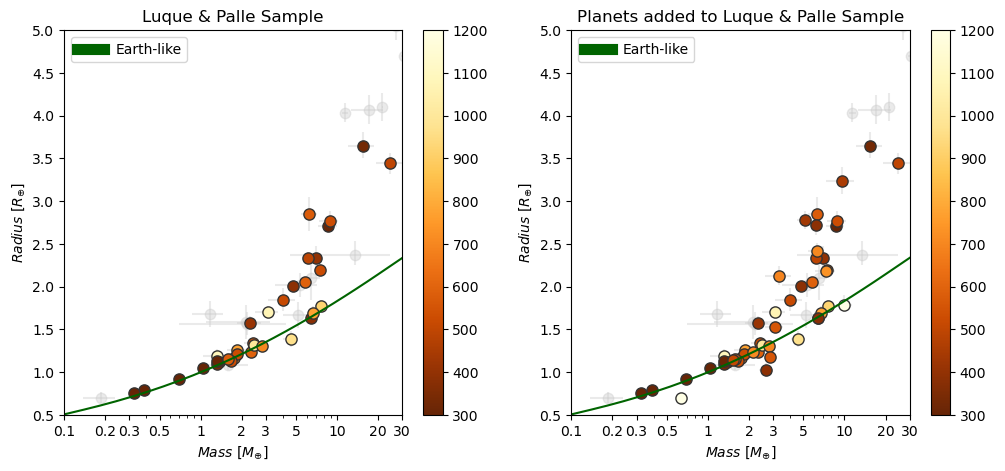

In [321]:
fig, ax = plt.subplots(figsize=(12,5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
mass_err_LI   = [mass_unc_low_LI,mass_unc_up_LI]
radius_err_LI = [radius_unc_low_LI,radius_unc_up_LI]
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like")

norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
densities = []
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        plt.scatter(mass_LI[i], radius_LI[i], c=[pl_eq_LI[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
        densities.append(density_LI[i])
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("Luque & Palle Sample")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.errorbar(mass_LI,radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.errorbar(mass2,radius2,xerr = [np.abs(mass_low2),mass_up2],yerr = [np.abs(radius_low2),np.abs(radius_up2)],fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like")
norm = mcolors.Normalize(vmin=300, vmax=1200)  # Set the desired min and max values
cmap = plt.cm.get_cmap('YlOrBr_r')
densities = []
for i in range(0,len(temps)):
    if planet_name[i] in planets or planet_name[i] in planet2:
        plt.scatter(masses_add[i], radii_add[i], c=[temps[i]], cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
cbar = plt.colorbar()

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log"); plt.xlim(0.1,30); plt.ylim(0.5,5)
plt.xticks([0.1,0.2,0.3,0.5,1,2,3,5,10,20, 30],["0.1","0.2","0.3","0.5","1","2","3","5","10","20", "30"],minor=False)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("Planets added to Luque & Palle Sample")
image_name = 'LIV34_add_RM.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)
